<a href="https://colab.research.google.com/github/noahbean33/quantum_computing_experiments/blob/main/classical_monte_carlo_vs_quantum_vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance cirq numpy pandas scipy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.6 MB/s eta 0:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize

# Step 1: Fetch stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Step 2: Define the objective function (e.g., negative Sharpe ratio)
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Step 3: Update variational algorithm
# Define the ansatz (parameterized quantum circuit)
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [cirq.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))

# Simulate the circuit
simulator = cirq.Simulator()

def objective_function(theta):
    # Simulate the circuit with the current parameters
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    # Convert state vector to portfolio weights
    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    # Calculate the negative Sharpe ratio
    return negative_sharpe_ratio(weights, returns)

# Initial guess for parameters
initial_params = np.random.rand(len(qubits))

# Optimize parameters
result = minimize(objective_function, initial_params, method='COBYLA')
optimal_params = result.x

# Display the results
optimal_weights = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights /= np.sum(optimal_weights)

optimal_weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight': optimal_weights
})

print(optimal_weights_df)


[*********************100%%**********************]  5 of 5 completed


AttributeError: module 'cirq' has no attribute 'Symbol'

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize

# Step 1: Fetch stock data
tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Step 2: Define the objective function (e.g., negative Sharpe ratio)
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Step 3: Update variational algorithm
# Define the ansatz (parameterized quantum circuit)
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

#params = [cirq.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))

# Simulate the circuit
simulator = cirq.Simulator()

def objective_function(theta):
    # Simulate the circuit with the current parameters
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    # Convert state vector to portfolio weights
    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    # Calculate the negative Sharpe ratio
    return negative_sharpe_ratio(weights, returns)

# Initial guess for parameters
initial_params = np.random.rand(len(qubits))

# Optimize parameters
result = minimize(objective_function, initial_params, method='COBYLA')
optimal_params = result.x

# Display the results
optimal_weights = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights /= np.sum(optimal_weights)

optimal_weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight': optimal_weights
})

print(optimal_weights_df)


[*********************100%%**********************]  5 of 5 completed


  Ticker  Optimal Weight
0   MSFT    9.438449e-01
1   AAPL    3.027787e-10
2  GOOGL    8.877633e-09
3   AMZN    2.847882e-18
4   META    5.615512e-02


In [5]:
!pip install cirq --upgrade --quiet
import sympy

# ... (rest of your code)

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits))]

# ... (rest of your code)

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize

# Step 1: Fetch stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Step 2: Define the objective function (e.g., negative Sharpe ratio)
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Step 3: Update variational algorithm
# Define the ansatz (parameterized quantum circuit)
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

#params = [cirq.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))

# Simulate the circuit
simulator = cirq.Simulator()

def objective_function(theta):
    # Simulate the circuit with the current parameters
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    # Convert state vector to portfolio weights
    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    # Calculate the negative Sharpe ratio
    return negative_sharpe_ratio(weights, returns)

# Define the constraints for diversification
def constraint(weights):
    return weights - 0.5

# Initial guess for parameters
initial_params = np.random.rand(len(qubits))

# Optimize parameters with constraints
constraints = ({'type': 'ineq', 'fun': constraint})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

# Display the results
optimal_weights = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights /= np.sum(optimal_weights)

optimal_weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight': optimal_weights
})

print(optimal_weights_df)


[*********************100%%**********************]  5 of 5 completed


  Ticker  Optimal Weight
0   AAPL        0.763310
1   MSFT        0.049767
2  GOOGL        0.049767
3   AMZN        0.003245
4   META        0.133910


Portfolio Return: 23.30%
Portfolio Volatility: 34.89%
Sharpe Ratio: 0.64


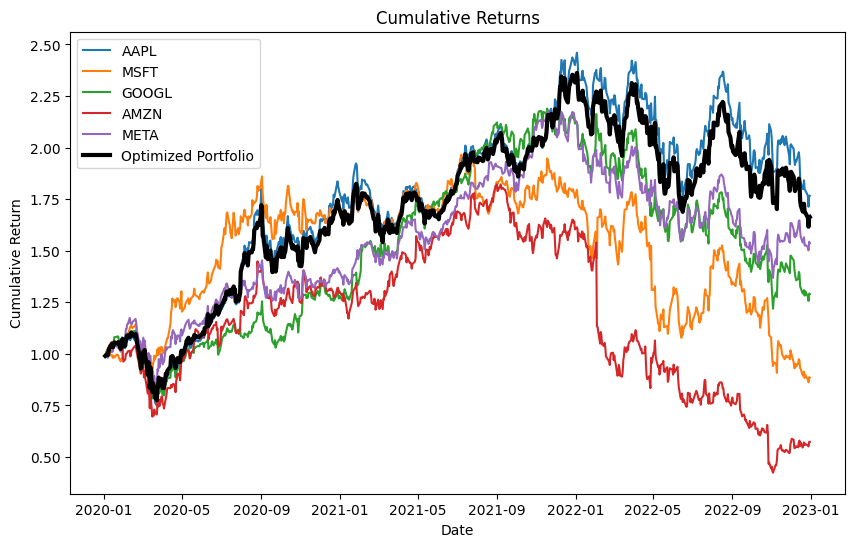

In [9]:
import matplotlib.pyplot as plt

# Calculate the portfolio return and volatility
portfolio_return = calculate_portfolio_return(optimal_weights, returns)
portfolio_volatility = calculate_portfolio_volatility(optimal_weights, returns)
sharpe_ratio = (portfolio_return - 0.01) / portfolio_volatility

print(f'Portfolio Return: {portfolio_return:.2%}')
print(f'Portfolio Volatility: {portfolio_volatility:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns = (cumulative_returns * optimal_weights).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns, label='Optimized Portfolio', linewidth=3, color='black')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  5 of 5 completed


Quantum Optimization Results:
  Ticker  Optimal Weight (Quantum)
0   AAPL                  0.763244
1   MSFT                  0.049763
2  GOOGL                  0.049763
3   AMZN                  0.003245
4   META                  0.133986
Return: 23.30%, Volatility: 34.89%, Sharpe Ratio: 0.64

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.668557
MSFT    MSFT                      0.038295
GOOGL  GOOGL                      0.114651
AMZN    AMZN                      0.003666
META    META                      0.174832
Return: 22.58%, Volatility: 34.19%, Sharpe Ratio: 0.63


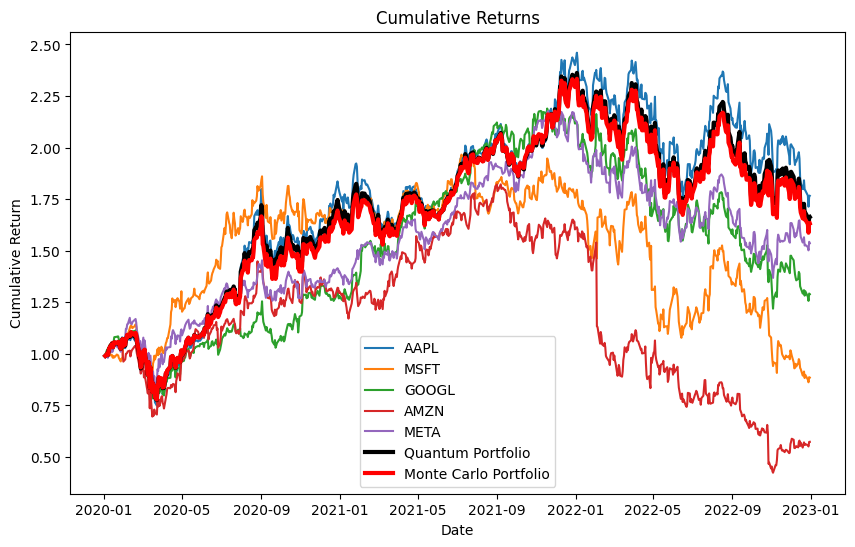

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

#params = [cirq.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(qubits))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0     MRK                  0.606382
1    MSFT                  0.039536
2   GOOGL                  0.039536
3    AMZN                  0.002578
4    META                  0.039536
5    TSLA                  0.002578
6    NVDA                  0.002578
7     JPM                  0.000168
8     JNJ                  0.183886
9       V                  0.011989
10     PG                  0.011989
11    DIS                  0.000782
12   PYPL                  0.011989
13   ADBE                  0.000782
14   NFLX                  0.000782
15   CSCO                  0.000051
16    XOM                  0.039536
17     KO                  0.002578
18    PFE                  0.002578
19   AAPL                  0.000168
Return: 18.27%, Volatility: 30.65%, Sharpe Ratio: 0.56

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
MRK      MRK                      0.014708
MSFT    MSFT                      0.03

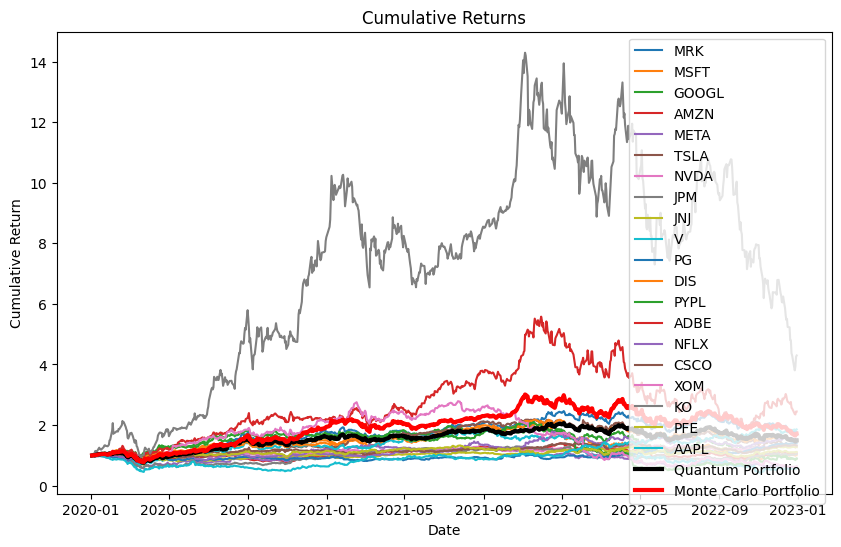

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy

# Fetch stock data
tickers = [
    'MRK', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'AAPL'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(qubits))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL              3.703957e-01
1    MSFT              1.052272e-08
2   GOOGL              4.809480e-02
3    AMZN              1.366344e-09
4    META              4.809480e-02
5    TSLA              1.366344e-09
6    NVDA              6.244966e-03
7     JPM              1.774157e-10
8     JNJ              3.703955e-01
9       V              1.052271e-08
10     PG              4.809476e-02
11    DIS              1.366343e-09
12   PYPL              4.809473e-02
13   ADBE              1.366342e-09
14   NFLX              6.244960e-03
15   CSCO              1.774155e-10
16    XOM              4.809481e-02
17     KO              1.366344e-09
18    PFE              6.244966e-03
19    MRK              1.774157e-10
Return: 14.65%, Volatility: 25.93%, Sharpe Ratio: 0.53

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.021533
MSFT    MSFT                      0.00

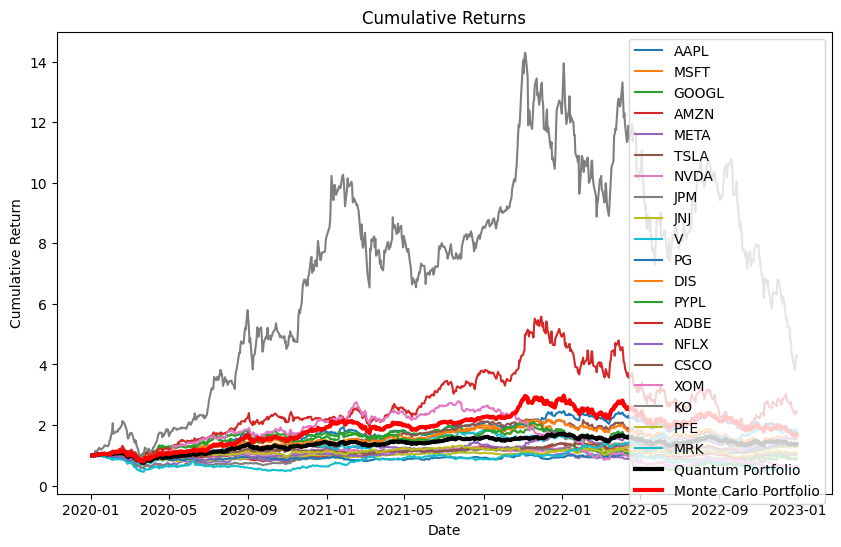

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits))]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[i])(qubit))
    circuit.append(cirq.ry(params[i])(qubit))
    circuit.append(cirq.rz(params[i])(qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(qubits))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL                  0.469436
1    MSFT                  0.060955
2   GOOGL                  0.007915
3    AMZN                  0.060955
4    META                  0.007915
5    TSLA                  0.001028
6    NVDA                  0.007915
7     JPM                  0.060955
8     JNJ                  0.026075
9       V                  0.003386
10     PG                  0.000440
11    DIS                  0.003386
12   PYPL                  0.026075
13   ADBE                  0.003386
14   NFLX                  0.026075
15   CSCO                  0.200817
16    XOM                  0.026075
17     KO                  0.003386
18    PFE                  0.000440
19    MRK                  0.003386
Return: 17.69%, Volatility: 28.16%, Sharpe Ratio: 0.59

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.031815
MSFT    MSFT                      0.01

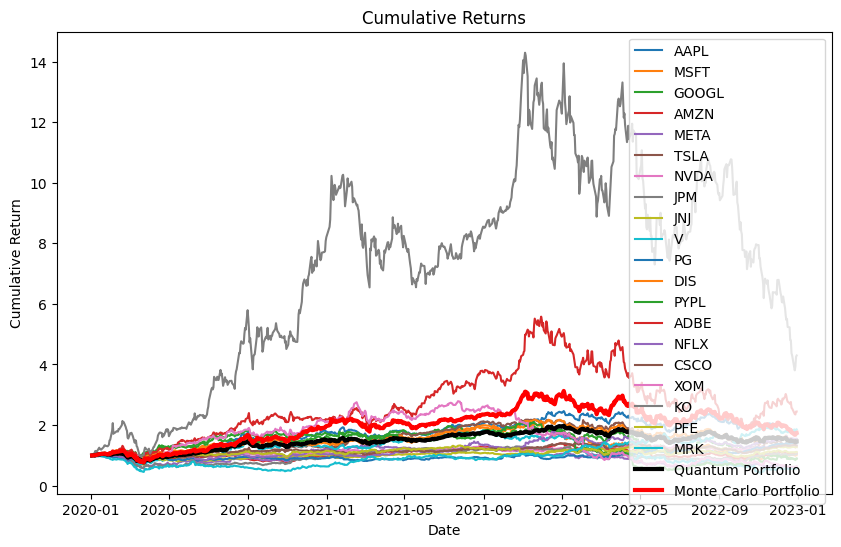

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 3)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(params[3 * i])(qubit))
    circuit.append(cirq.ry(params[3 * i + 1])(qubit))
    circuit.append(cirq.rz(params[3 * i + 2])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(params))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL              2.186614e-12
1    MSFT              6.214276e-12
2   GOOGL              1.766041e-11
3    AMZN              6.214157e-12
4    META              1.766007e-11
5    TSLA              5.018928e-11
6    NVDA              1.766041e-11
7     JPM              6.214157e-12
8     JNJ              1.085700e-02
9       V              3.085518e-02
10     PG              8.768762e-02
11    DIS              3.085458e-02
12   PYPL              1.085699e-02
13   ADBE              3.085517e-02
14   NFLX              1.085720e-02
15   CSCO              3.820316e-03
16    XOM              5.307119e-02
17     KO              1.508264e-01
18    PFE              4.286349e-01
19    MRK              1.508235e-01
Return: 22.96%, Volatility: 30.53%, Sharpe Ratio: 0.72

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.128803
MSFT    MSFT                      0.04

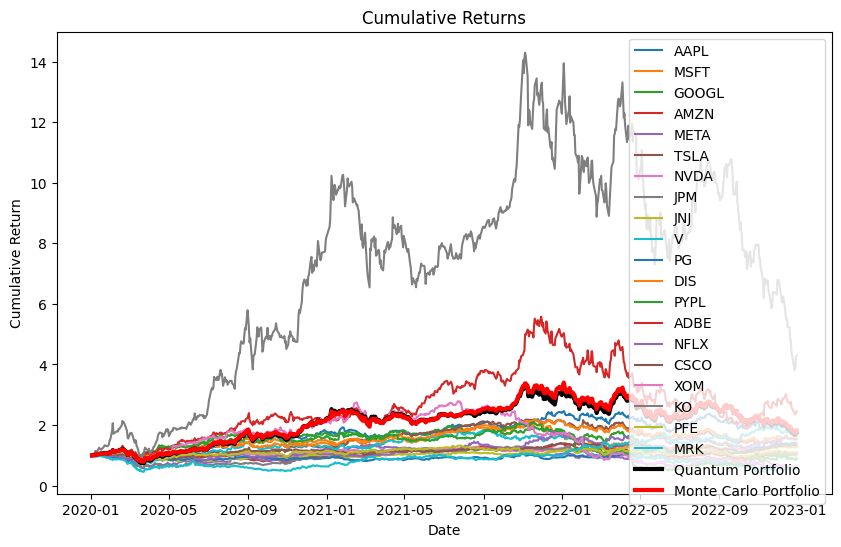

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 3)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.H(qubit))  # Add Hadamard gate for superposition
    circuit.append(cirq.rx(params[3 * i])(qubit))
    circuit.append(cirq.ry(params[3 * i + 1])(qubit))
    circuit.append(cirq.rz(params[3 * i + 2])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(params))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL              1.334600e-10
1    MSFT              3.792922e-10
2   GOOGL              1.077914e-09
3    AMZN              3.792814e-10
4    META              1.077883e-09
5    TSLA              3.063334e-09
6    NVDA              1.077914e-09
7     JPM              3.792814e-10
8     JNJ              1.085069e-02
9       V              3.083757e-02
10     PG              8.763756e-02
11    DIS              3.083669e-02
12   PYPL              1.085069e-02
13   ADBE              3.083756e-02
14   NFLX              1.085100e-02
15   CSCO              3.818099e-03
16    XOM              5.307922e-02
17     KO              1.508506e-01
18    PFE              4.287039e-01
19    MRK              1.508463e-01
Return: 22.96%, Volatility: 30.53%, Sharpe Ratio: 0.72

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.103373
MSFT    MSFT                      0.01

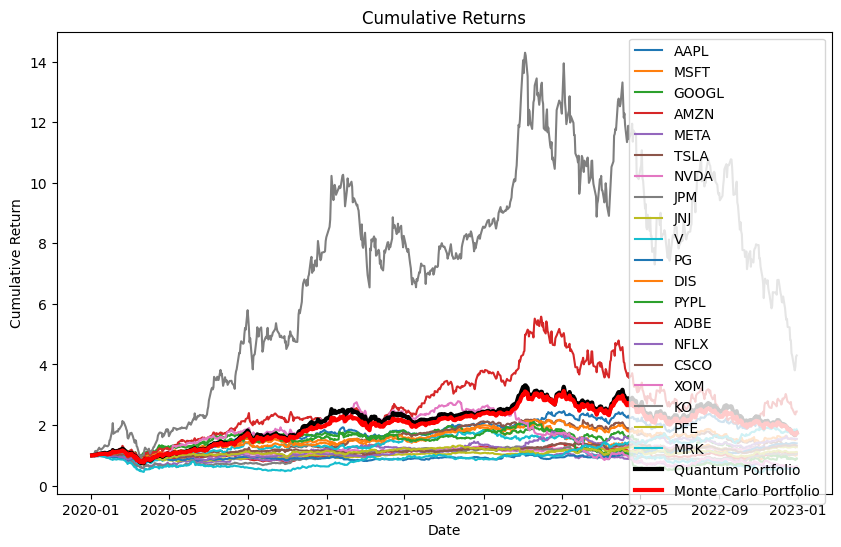

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Classical optimization to initialize parameters
def classical_optimization():
    num_assets = len(tickers)
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

classical_weights = classical_optimization()

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 3)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.H(qubit))  # Add Hadamard gate for superposition
    circuit.append(cirq.rx(params[3 * i])(qubit))
    circuit.append(cirq.ry(params[3 * i + 1])(qubit))
    circuit.append(cirq.rz(params[3 * i + 2])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

initial_params = np.random.rand(len(params))
constraints = ({'type': 'ineq', 'fun': lambda weights: weights - 0.5})
result = minimize(objective_function, initial_params, method='COBYLA', constraints=constraints)
optimal_params = result.x

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL                  0.001213
1    MSFT                  0.006206
2   GOOGL                  0.020276
3    AMZN                  0.003963
4    META                  0.009751
5    TSLA                  0.049886
6    NVDA                  0.015268
7     JPM                  0.002984
8     JNJ                  0.010780
9       V                  0.055149
10     PG                  0.180192
11    DIS                  0.035221
12   PYPL                  0.014315
13   ADBE                  0.073238
14   NFLX                  0.022415
15   CSCO                  0.004381
16    XOM                  0.018957
17     KO                  0.096984
18    PFE                  0.316884
19    MRK                  0.061939
Return: 19.89%, Volatility: 28.14%, Sharpe Ratio: 0.67

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.056411
MSFT    MSFT                      0.00

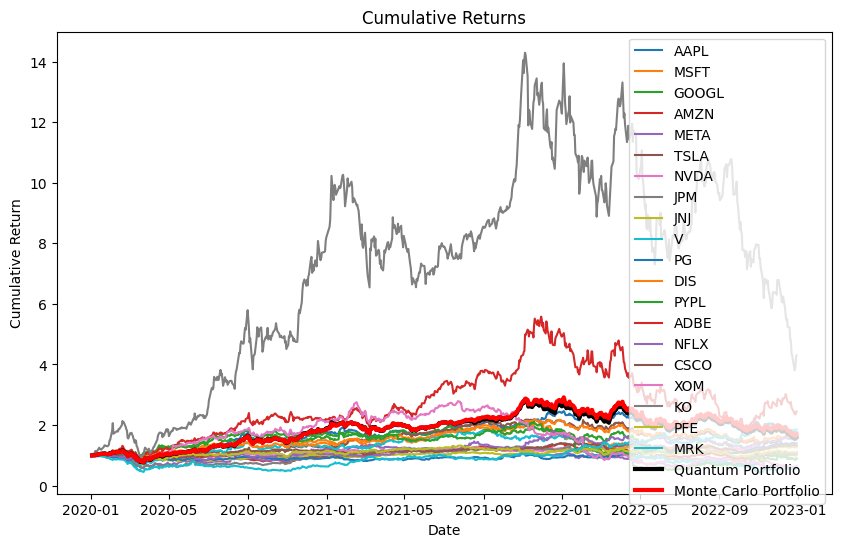

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy
from scipy.optimize import differential_evolution

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Classical optimization to initialize parameters
def classical_optimization():
    num_assets = len(tickers)
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

classical_weights = classical_optimization()

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 3)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.H(qubit))  # Add Hadamard gate for superposition
    circuit.append(cirq.rx(params[3 * i])(qubit))
    circuit.append(cirq.ry(params[3 * i + 1])(qubit))
    circuit.append(cirq.rz(params[3 * i + 2])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

# SPSA optimizer
def spsa_optimizer(objective_function, initial_params, maxiter=100):
    alpha = 0.602
    gamma = 0.101
    a = 0.16
    c = 0.1
    A = 0.01 * maxiter
    params = np.copy(initial_params)
    for k in range(maxiter):
        ak = a / (A + k + 1)**alpha
        ck = c / (k + 1)**gamma
        delta = 2 * np.random.randint(2, size=len(params)) - 1
        params_plus = params + ck * delta
        params_minus = params - ck * delta
        objective_plus = objective_function(params_plus)
        objective_minus = objective_function(params_minus)
        gradient = (objective_plus - objective_minus) / (2 * ck * delta)
        params = params - ak * gradient
    return params

initial_params = np.random.rand(len(params))
optimal_params = spsa_optimizer(objective_function, initial_params, maxiter=200)

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [19]:
!pip install seaborn


[*********************100%%**********************]  20 of 20 completed


Quantum Optimization Results:
   Ticker  Optimal Weight (Quantum)
0    AAPL                  0.000887
1    MSFT                  0.002074
2   GOOGL                  0.007078
3    AMZN                  0.003027
4    META                  0.010804
5    TSLA                  0.025264
6    NVDA                  0.007402
7     JPM                  0.003166
8     JNJ                  0.019064
9       V                  0.044579
10     PG                  0.152145
11    DIS                  0.065066
12   PYPL                  0.018228
13   ADBE                  0.042624
14   NFLX                  0.012489
15   CSCO                  0.005341
16    XOM                  0.039422
17     KO                  0.092182
18    PFE                  0.314612
19    MRK                  0.134545
Return: 19.85%, Volatility: 27.92%, Sharpe Ratio: 0.67

Monte Carlo Optimization Results:
      Ticker  Optimal Weight (Monte Carlo)
AAPL    AAPL                      0.022436
MSFT    MSFT                      0.01

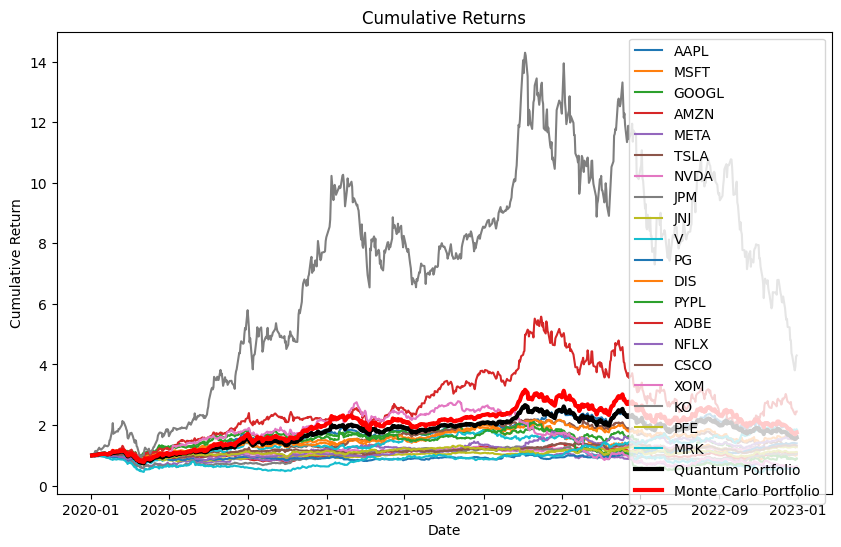

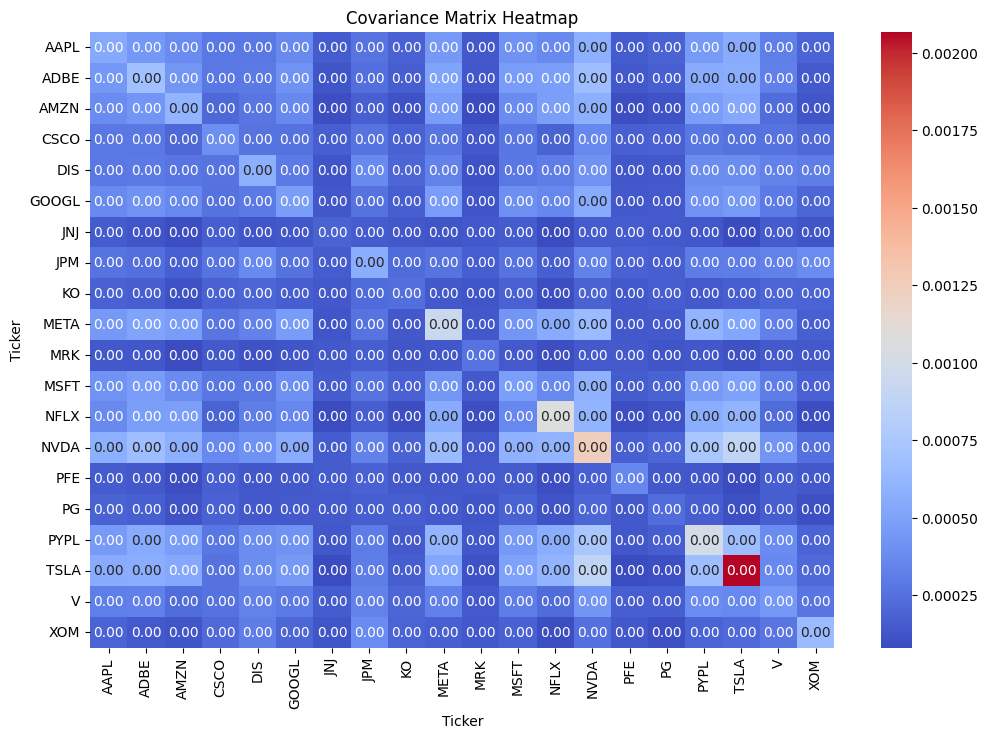

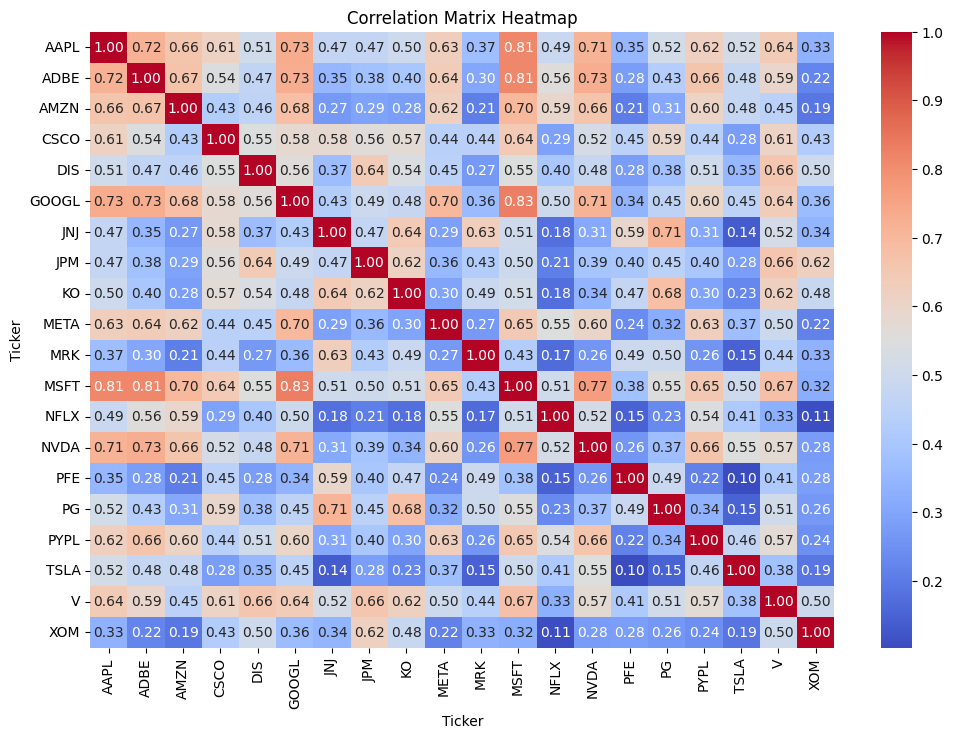

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import sympy

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Classical optimization to initialize parameters
def classical_optimization():
    num_assets = len(tickers)
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

classical_weights = classical_optimization()

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 3)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.H(qubit))  # Add Hadamard gate for superposition
    circuit.append(cirq.rx(params[3 * i])(qubit))
    circuit.append(cirq.ry(params[3 * i + 1])(qubit))
    circuit.append(cirq.rz(params[3 * i + 2])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, returns)

# SPSA optimizer
def spsa_optimizer(objective_function, initial_params, maxiter=100):
    alpha = 0.602
    gamma = 0.101
    a = 0.16
    c = 0.1
    A = 0.01 * maxiter
    params = np.copy(initial_params)
    for k in range(maxiter):
        ak = a / (A + k + 1)**alpha
        ck = c / (k + 1)**gamma
        delta = 2 * np.random.randint(2, size=len(params)) - 1
        params_plus = params + ck * delta
        params_minus = params - ck * delta
        objective_plus = objective_function(params_plus)
        objective_minus = objective_function(params_minus)
        gradient = (objective_plus - objective_minus) / (2 * ck * delta)
        params = params - ak * gradient
    return params

initial_params = np.random.rand(len(params))
optimal_params = spsa_optimizer(objective_function, initial_params, maxiter=200)

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Covariance and Correlation Heat Maps
plt.figure(figsize=(12, 8))
sns.heatmap(returns.cov(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


[*********************100%%**********************]  20 of 20 completed


Shapiro-Wilk Test Results:
AAPL: W-statistic=0.9539733529090881, p-value=1.283546125017531e-14
MSFT: W-statistic=0.9342848062515259, p-value=1.0325009853771638e-17
GOOGL: W-statistic=0.9602332711219788, p-value=1.9261231064965356e-13
AMZN: W-statistic=0.958780825138092, p-value=1.0025336274034971e-13
META: W-statistic=0.8550318479537964, p-value=9.376721194199692e-26
TSLA: W-statistic=0.9620010852813721, p-value=4.359286098331444e-13
NVDA: W-statistic=0.9804659485816956, p-value=1.687947914774668e-08
JPM: W-statistic=0.8933961987495422, p-value=1.9406831500391977e-22
JNJ: W-statistic=0.8885705471038818, p-value=6.68944833732045e-23
V: W-statistic=0.9168041348457336, p-value=6.095392475031252e-20
PG: W-statistic=0.865263819694519, p-value=6.077266084686892e-25
DIS: W-statistic=0.9149460196495056, p-value=3.706374989412774e-20
PYPL: W-statistic=0.9247165322303772, p-value=5.582598010150342e-19
ADBE: W-statistic=0.9184815287590027, p-value=9.618763770556899e-20
NFLX: W-statistic=0.8170864

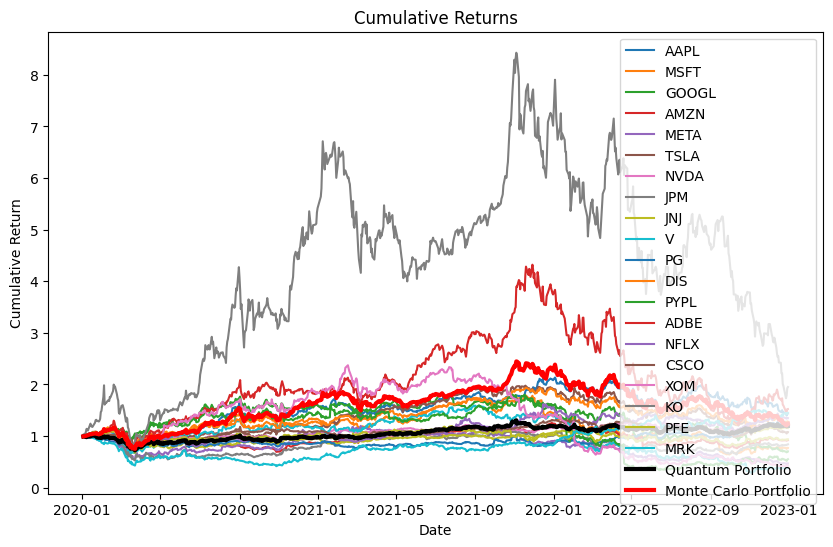

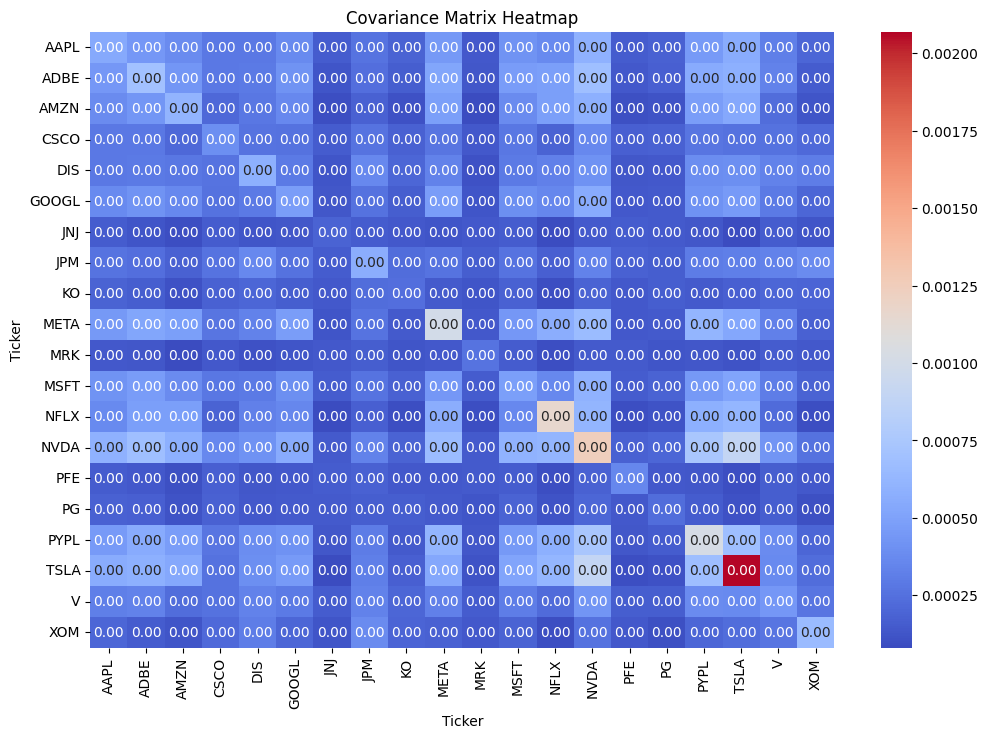

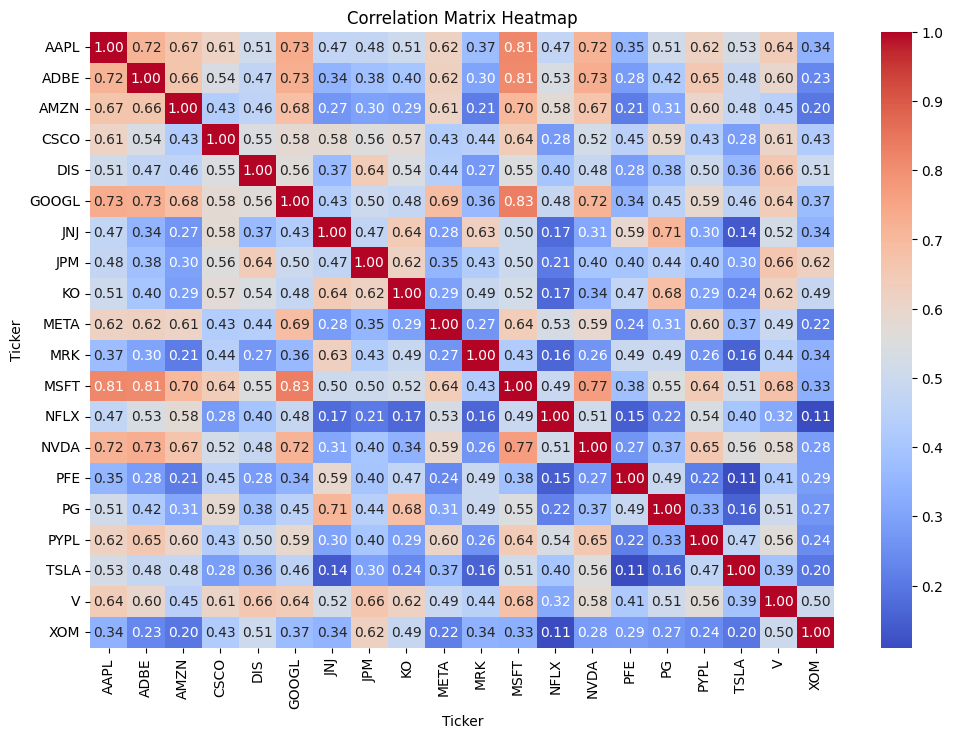

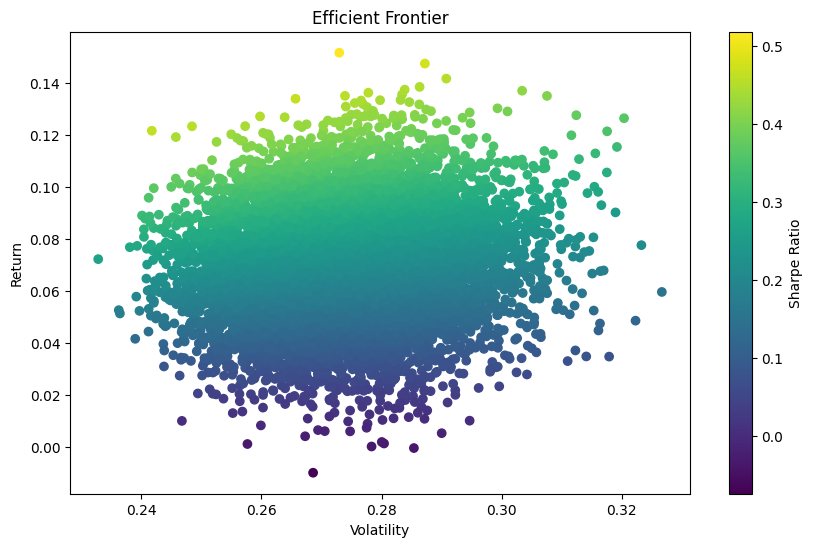

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import cirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import sympy
from scipy.stats import shapiro, normaltest

# Fetch stock data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V',
    'PG', 'DIS', 'PYPL', 'ADBE', 'NFLX', 'CSCO', 'XOM', 'KO', 'PFE', 'MRK'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Normality tests
shapiro_results = {ticker: shapiro(log_returns[ticker]) for ticker in tickers}
normaltest_results = {ticker: normaltest(log_returns[ticker]) for ticker in tickers}

# Display normality test results
print("Shapiro-Wilk Test Results:")
for ticker, result in shapiro_results.items():
    print(f"{ticker}: W-statistic={result[0]}, p-value={result[1]}")

print("\nD'Agostino's K-squared Test Results:")
for ticker, result in normaltest_results.items():
    print(f"{ticker}: K2-statistic={result[0]}, p-value={result[1]}")

# Define portfolio metrics
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return = calculate_portfolio_return(weights, returns)
    p_volatility = calculate_portfolio_volatility(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

# Classical optimization to initialize parameters
def classical_optimization(risk_free_rate=0.01):
    num_assets = len(tickers)
    args = (log_returns, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# Varying risk-free rates
risk_free_rates = [0.01, 0.02, 0.03]
optimal_weights_classical = {rate: classical_optimization(rate) for rate in risk_free_rates}

# Quantum variational algorithm
qubits = cirq.GridQubit.rect(1, len(tickers))
circuit = cirq.Circuit()

params = [sympy.Symbol(f'theta_{i}') for i in range(len(qubits) * 5)]
for i, qubit in enumerate(qubits):
    circuit.append(cirq.H(qubit))  # Add Hadamard gate for superposition
    circuit.append(cirq.rx(params[5 * i])(qubit))
    circuit.append(cirq.ry(params[5 * i + 1])(qubit))
    circuit.append(cirq.rz(params[5 * i + 2])(qubit))
    circuit.append(cirq.rx(params[5 * i + 3])(qubit))
    circuit.append(cirq.ry(params[5 * i + 4])(qubit))
    if i > 0:
        circuit.append(cirq.CNOT(qubits[i - 1], qubit))

simulator = cirq.Simulator()

def objective_function(theta):
    resolver = cirq.ParamResolver({f'theta_{i}': theta[i] for i in range(len(theta))})
    result = simulator.simulate(circuit, param_resolver=resolver)
    state_vector = result.final_state_vector

    weights = np.abs(state_vector[:len(tickers)])**2
    weights /= np.sum(weights)

    return negative_sharpe_ratio(weights, log_returns)

# SPSA optimizer
def spsa_optimizer(objective_function, initial_params, maxiter=100):
    alpha = 0.602
    gamma = 0.101
    a = 0.16
    c = 0.1
    A = 0.01 * maxiter
    params = np.copy(initial_params)
    for k in range(maxiter):
        ak = a / (A + k + 1)**alpha
        ck = c / (k + 1)**gamma
        delta = 2 * np.random.randint(2, size=len(params)) - 1
        params_plus = params + ck * delta
        params_minus = params - ck * delta
        objective_plus = objective_function(params_plus)
        objective_minus = objective_function(params_minus)
        gradient = (objective_plus - objective_minus) / (2 * ck * delta)
        params = params - ak * gradient
    return params

initial_params = np.random.rand(len(params))
optimal_params = spsa_optimizer(objective_function, initial_params, maxiter=200)

optimal_weights_quantum = np.abs(simulator.simulate(circuit, param_resolver=cirq.ParamResolver(
    {f'theta_{i}': optimal_params[i] for i in range(len(optimal_params))})).final_state_vector[:len(tickers)])**2
optimal_weights_quantum /= np.sum(optimal_weights_quantum)

# Monte Carlo simulation
num_portfolios = 10000
results = np.zeros((num_portfolios, len(tickers) + 3))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    p_return = calculate_portfolio_return(weights, log_returns)
    p_volatility = calculate_portfolio_volatility(weights, log_returns)
    sharpe_ratio = (p_return - 0.01) / p_volatility

    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = p_return
    results[i, len(tickers) + 1] = p_volatility
    results[i, len(tickers) + 2] = sharpe_ratio

results_df = pd.DataFrame(results, columns=[*tickers, 'Return', 'Volatility', 'Sharpe Ratio'])
optimal_mc = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

# Performance metrics
portfolio_return_quantum = calculate_portfolio_return(optimal_weights_quantum, log_returns)
portfolio_volatility_quantum = calculate_portfolio_volatility(optimal_weights_quantum, log_returns)
sharpe_ratio_quantum = (portfolio_return_quantum - 0.01) / portfolio_volatility_quantum

portfolio_return_mc = optimal_mc['Return']
portfolio_volatility_mc = optimal_mc['Volatility']
sharpe_ratio_mc = optimal_mc['Sharpe Ratio']

# Display results
optimal_weights_df_quantum = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Quantum)': optimal_weights_quantum
})

optimal_weights_df_mc = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (Monte Carlo)': optimal_mc[:len(tickers)]
})

print("Quantum Optimization Results:")
print(optimal_weights_df_quantum)
print(f"Return: {portfolio_return_quantum:.2%}, Volatility: {portfolio_volatility_quantum:.2%}, Sharpe Ratio: {sharpe_ratio_quantum:.2f}")

print("\nMonte Carlo Optimization Results:")
print(optimal_weights_df_mc)
print(f"Return: {portfolio_return_mc:.2%}, Volatility: {portfolio_volatility_mc:.2%}, Sharpe Ratio: {sharpe_ratio_mc:.2f}")

# Plot cumulative returns
cumulative_returns = (log_returns + 1).cumprod()
portfolio_cumulative_returns_quantum = (cumulative_returns * optimal_weights_quantum).sum(axis=1)
portfolio_cumulative_returns_mc = (cumulative_returns * optimal_mc[:len(tickers)].values).sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label=tickers)
plt.plot(portfolio_cumulative_returns_quantum, label='Quantum Portfolio', linewidth=3, color='black')
plt.plot(portfolio_cumulative_returns_mc, label='Monte Carlo Portfolio', linewidth=3, color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Covariance and Correlation Heat Maps
plt.figure(figsize=(12, 8))
sns.heatmap(log_returns.cov(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(log_returns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Efficient Frontier
def calculate_efficient_frontier(num_portfolios, returns):
    results = np.zeros((num_portfolios, 3))
    weight_array = np.zeros((num_portfolios, len(returns.columns)))

    for i in range(num_portfolios):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        p_return = calculate_portfolio_return(weights, returns)
        p_volatility = calculate_portfolio_volatility(weights, returns)
        sharpe_ratio = (p_return - 0.01) / p_volatility

        results[i, 0] = p_return
        results[i, 1] = p_volatility
        results[i, 2] = sharpe_ratio
        weight_array[i, :] = weights

    return results, weight_array

num_portfolios = 10000
frontier_results, frontier_weights = calculate_efficient_frontier(num_portfolios, log_returns)

plt.figure(figsize=(10, 6))
plt.scatter(frontier_results[:, 1], frontier_results[:, 0], c=frontier_results[:, 2], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


In [25]:
!pip install qiskit==0.23.0 qiskit-terra==0.16.0 qiskit-aer==0.7.0 qiskit-ignis==0.5.0 qiskit-aqua==0.8.0


  Using cached qiskit-0.23.0.tar.gz (4.1 kB)
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user


In [24]:
import qiskit
from qiskit import Aer

print("Qiskit version:", qiskit.__version__)
print("Qiskit Aer version:", Aer.__version__)


ModuleNotFoundError: No module named 'qiskit'

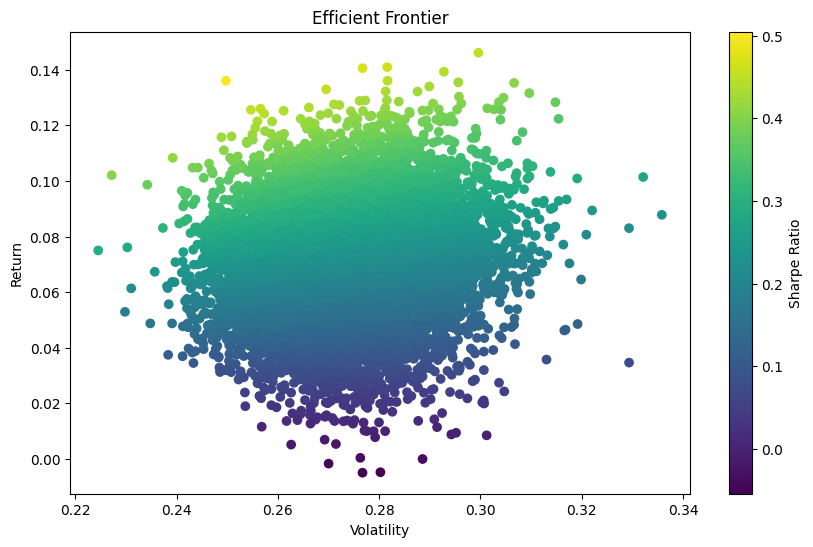

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate portfolio return
def calculate_portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights) * 252

# Function to calculate portfolio volatility
def calculate_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

# Function to calculate efficient frontier
def calculate_efficient_frontier(num_portfolios, returns):
    results = np.zeros((num_portfolios, 3))
    weight_array = np.zeros((num_portfolios, len(returns.columns)))

    for i in range(num_portfolios):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        p_return = calculate_portfolio_return(weights, returns)
        p_volatility = calculate_portfolio_volatility(weights, returns)
        sharpe_ratio = (p_return - 0.01) / p_volatility

        results[i, 0] = p_return
        results[i, 1] = p_volatility
        results[i, 2] = sharpe_ratio
        weight_array[i, :] = weights

    return results, weight_array

# Assuming 'log_returns' is the dataframe of log returns for your assets
num_portfolios = 10000
frontier_results, frontier_weights = calculate_efficient_frontier(num_portfolios, log_returns)

plt.figure(figsize=(10, 6))
plt.scatter(frontier_results[:, 1], frontier_results[:, 0], c=frontier_results[:, 2], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from qiskit import Aer, QuantumCircuit, transpile
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import shapiro, normaltest

# Step 1: Get Real-Time Stock Data
tickers = ['AAPL', 'AMZN', 'GOOGL', 'NFLX']
data = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Normality tests
shapiro_results = {ticker: shapiro(log_returns[ticker]) for ticker in tickers}
normaltest_results = {ticker: normaltest(log_returns[ticker]) for ticker in tickers}

# Display normality test results
print("Shapiro-Wilk Test Results:")
for ticker, result in shapiro_results.items():
    print(f"{ticker}: W-statistic={result[0]}, p-value={result[1]}")

print("\nD'Agostino's K-squared Test Results:")
for ticker, result in normaltest_results.items():
    print(f"{ticker}: K2-statistic={result[0]}, p-value={result[1]}")

cov_matrix = log_returns.cov()
corr_matrix = log_returns.corr()
expected_returns = log_returns.mean()
risk_free_rate = 0.03

# Visualize Covariance and Correlation Heatmaps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True, square=True, xticklabels=tickers, yticklabels=tickers)
plt.title('Covariance Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True, square=True, xticklabels=tickers, yticklabels=tickers)
plt.title('Correlation Matrix')
plt.show()

# Quantum Portfolio Optimization
def quantum_portfolio_optimization(mu, cov_matrix, risk_free_rate):
    num_assets = len(mu)

    # Define quantum circuit
    qc = QuantumCircuit(num_assets, num_assets)
    qc.h(range(num_assets))  # Apply Hadamard gate to all qubits

    # Add depth to the circuit
    for _ in range(3):
        for i in range(num_assets):
            qc.rx(np.pi/2, i)
            qc.ry(np.pi/2, i)
            qc.rz(np.pi/2, i)
        for i in range(num_assets - 1):
            qc.cx(i, i + 1)

    qc.measure(range(num_assets), range(num_assets))

    # Define simulator backend
    backend = Aer.get_backend('qasm_simulator')
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=1000).result()

    # Process results and calculate portfolio composition
    counts = result.get_counts(qc)
    portfolio_composition = np.zeros(num_assets)
    for state, count in counts.items():
        for i, bit in enumerate(state[::-1]):
            if bit == '1':
                portfolio_composition[i] += count

    portfolio_composition = portfolio_composition / sum(portfolio_composition)
    portfolio_value = sum([(mu[i] - risk_free_rate) * portfolio_composition[i] for i in range(num_assets)])

    return portfolio_composition, portfolio_value

# Classical Portfolio Optimization
def classical_portfolio_optimization(mu, cov_matrix, risk_free_rate):
    num_assets = len(mu)
    ones = np.ones(num_assets)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    expected_return = mu - risk_free_rate * ones
    w = np.dot(inv_cov_matrix, expected_return) / np.dot(ones, np.dot(inv_cov_matrix, expected_return))
    portfolio_return = np.dot(w, mu)
    portfolio_std_dev = np.sqrt(np.dot(w, np.dot(cov_matrix, w)))

    return w, portfolio_return, portfolio_std_dev

# Calculate time taken for classical optimization
start_time_classical = time.time()
weights_classical, expected_return_classical, std_dev_classical = classical_portfolio_optimization(expected_returns, cov_matrix, risk_free_rate)
end_time_classical = time.time()
time_classical = end_time_classical - start_time_classical

# Calculate time taken for quantum optimization
start_time_quantum = time.time()
portfolio_composition_quantum, portfolio_value_quantum = quantum_portfolio_optimization(expected_returns, cov_matrix, risk_free_rate)
end_time_quantum = time.time()
time_quantum = end_time_quantum - start_time_quantum

# Print classical optimization results
print(f'Classical Portfolio Optimization Results:')
print(f'Weights: {weights_classical}')
print(f'Expected Return: {expected_return_classical}')
print(f'Standard Deviation: {std_dev_classical}')

# Print quantum optimization results
print(f'Quantum Portfolio Optimization Results:')
print(f'Portfolio Composition: {portfolio_composition_quantum}')
print(f'Portfolio Value: {portfolio_value_quantum}')

# Visualize the portfolio composition (Quantum)
plt.figure(figsize=(8, 6))
plt.bar(expected_returns.index, portfolio_composition_quantum)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Composition (Quantum)')
plt.xticks(rotation=45)
plt.show()

# Compare classical and quantum portfolio compositions
plt.figure(figsize=(10, 6))
plt.bar(expected_returns.index, weights_classical, alpha=0.5, color='blue', label='Classical')
plt.bar(expected_returns.index, portfolio_composition_quantum, alpha=0.5, color='green', label='Quantum')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Composition Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Compare performance
methods = ['Classical', 'Quantum']
times = [time_classical, time_quantum]
plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'])
plt.xlabel('Methods')
plt.ylabel('Execution Time (seconds)')
plt.title('Portfolio Optimization Performance Comparison')
plt.show()

# Function for Monte Carlo Simulation Forecasting (ABM and GBM)
def monte_carlo_forecast(start_price, days, mean, std_dev, model='GBM'):
    dt = 1/252  # Assuming trading days in a year
    num_simulations = 1000  # Number of simulations
    price_paths = np.zeros((num_simulations, days+1))

    for i in range(num_simulations):
        Z = np.random.normal(0, 1, days)
        if model == 'GBM':
            daily_returns = np.exp((mean - (std_dev**2) / 2) * dt + std_dev * np.sqrt(dt) * Z)
        elif model == 'ABM':
            daily_returns = mean * dt + std_dev * np.sqrt(dt) * Z
        price_path = np.zeros(days+1)
        price_path[0] = start_price
        for t in range(1, days+1):
            price_path[t] = price_path[t-1] * daily_returns[t-1]
        price_paths[i, :] = price_path

    return price_paths

# Perform Monte Carlo Simulation for Forecasting (GBM and ABM)
start_price = data.iloc[-1]['AAPL']
forecast_days = 30
mean_daily_return = log_returns.mean().mean()
std_dev_daily_return = log_returns.std().mean()
monte_carlo_prices_gbm = monte_carlo_forecast(start_price, forecast_days, mean_daily_return, std_dev_daily_return, model='GBM')
monte_carlo_prices_abm = monte_carlo_forecast(start_price, forecast_days, mean_daily_return, std_dev_daily_return, model='ABM')

# Plot Monte Carlo Simulation for GBM
plt.figure(figsize=(12, 6))
for i in range(monte_carlo_prices_gbm.shape[0]):
    plt.plot(range(forecast_days+1), monte_carlo_prices_gbm[i, :], color='blue', alpha=0.2, linewidth=1)
plt.title('Monte Carlo Simulation for Stock Price Forecasting (GBM)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Plot Monte Carlo Simulation for ABM
plt.figure(figsize=(12, 6))
for i in range(monte_carlo_prices_abm.shape[0]):
    plt.plot(range(forecast_days+1), monte_carlo_prices_abm[i, :], color='green', alpha=0.2, linewidth=1)
plt.title('Monte Carlo Simulation for Stock Price Forecasting (ABM)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Efficient Frontier
def calculate_efficient_frontier(num_portfolios, returns):
    results = np.zeros((num_portfolios, 3))
    weight_array = np.zeros((num_portfolios, len(returns.columns)))

    for i in range(num_portfolios):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        p_return = calculate_portfolio_return(weights, returns)
        p_volatility = calculate_portfolio_volatility(weights, returns)
        sharpe_ratio = (p_return - 0.01) / p_volatility

        results[i, 0] = p_return
        results[i, 1] = p_volatility
        results[i, 2] = sharpe_ratio
        weight_array[i, :] = weights

    return results, weight_array

num_portfolios = 10000
frontier_results, frontier_weights = calculate_efficient_frontier(num_portfolios, log_returns)

plt.figure(figsize=(10, 6))
plt.scatter(frontier_results[:, 1], frontier_results[:, 0], c=frontier_results[:, 2], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()
